In [1]:
from implicit_filter import NemoFilter 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import math

# Load NEMO data

---

Remember to exclude redundant data at the borders

In [2]:
s = xr.open_dataset("../FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_U.nc")
ttu = s.vozocrtx.isel(time_counter=0, depthu=0, y=slice(None, -2), x=slice(None, -2)).transpose("x", "y").values
s = xr.open_dataset("../FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_V.nc")
ttv = s.vomecrty.isel(time_counter=0, depthv=0, y=slice(None, -2), x=slice(None, -2)).transpose("x", "y").values

### and NEMO mesh file path

In [3]:
mesh_file = "../mesh_mask.nc"

# Prepare the filter

---

Select vertical level (vl) that you want to use. This is necessary if you want to take into account partially filled cells and changes in topography. Otherwise you can set vertical level to 0 and the filter will use surface land mask to construct filter. 

In [4]:
filter = NemoFilter()
filter.prepare_from_file(file=mesh_file, vl=0, gpu=True) 

### Saving auxiliary arrays to file is supported as well

In [5]:
filter.save_to_file("../nemo_cash")

### Load it later 

In [6]:
filter = NemoFilter.load_from_file("../nemo_cash.npz")

# Filtering

---

### First define wavelength

In [7]:
dxm = 25 # Mesh resolution
Kc = np.array([2, 4, 5, 6, 8, 10, 12, 16]) * dxm
Kc = 2 * math.pi / Kc

### Apply filter

In [8]:
ttus, ttvs = filter.compute_velocity(1, Kc[-1], ttu, ttv) # Velocities are transformed to T cells

In [9]:
ttus = filter.compute(1, Kc[-1], ttu)

### Before

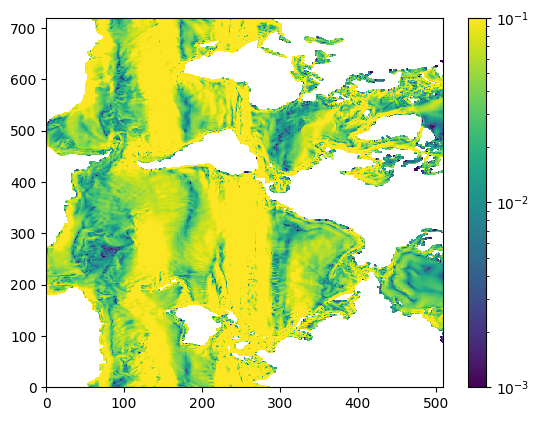

In [11]:
import matplotlib as mpl

plt.pcolor(np.sqrt(np.square(ttu) + np.square(ttv)), norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e-1))
plt.figsize=(20, 15)
plt.colorbar()

### After

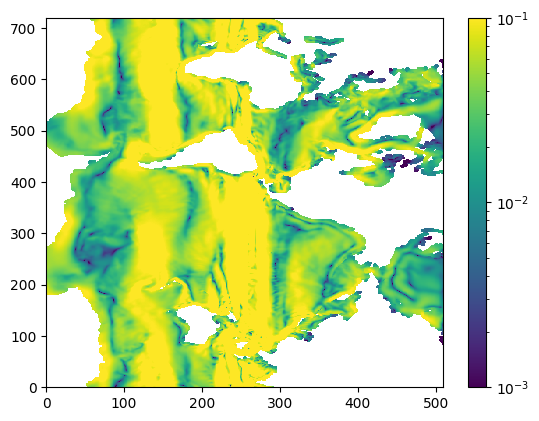

In [12]:
plt.pcolor(np.sqrt(np.square(ttus) + np.square(ttvs)), norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e-1))
plt.figsize=(20, 15)
plt.colorbar()

### Now one can use compute spectra method to get the spectra directly

In [13]:
spectra = filter.compute_spectra_velocity(1, Kc, ttu, ttv)

In [14]:
filter._area.shape

(366480,)

Text(0, 0.5, '$ \\bar E $')

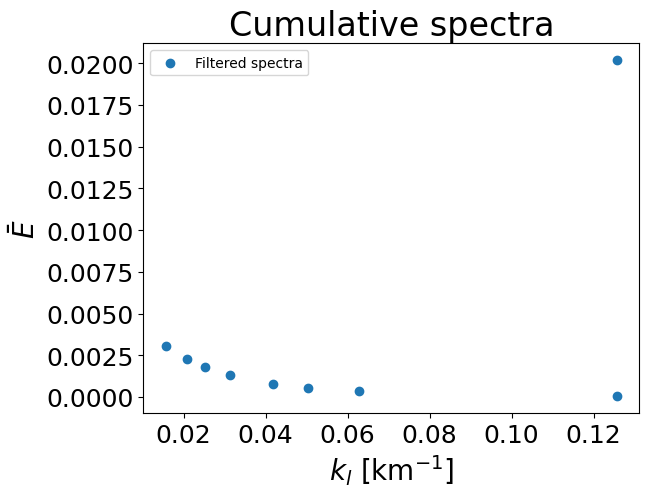

In [17]:
# Add the first element as spectra also contains value for unfiltered data on position 0
k = np.insert(Kc, 0, Kc[0])
plt.scatter(k, spectra, label="Filtered spectra")
plt.title("Cumulative spectra", fontsize=24)
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$k_l$ [km$^{-1}$]", fontsize=20)
plt.ylabel(r"$ \bar E $", fontsize=20)

In [19]:
k = np.insert(Kc, 0, Kc[0])
r = np.insert(2*math.pi/Kc, 0, 0)
dr = r[1:]-r[0:-1]
dk = k[1:] - k[0:-1]
kmid = np.sqrt(k[0:-1] * k[1:])
rmid = np.sqrt(r[0:-1] * r[1:])
de_high = spectra[1:] - spectra[0:-1]

Text(0, 0.5, '$\\partial \\bar E / \\partial k_l $ [$ \\frac{m^3}{s^2} $]')

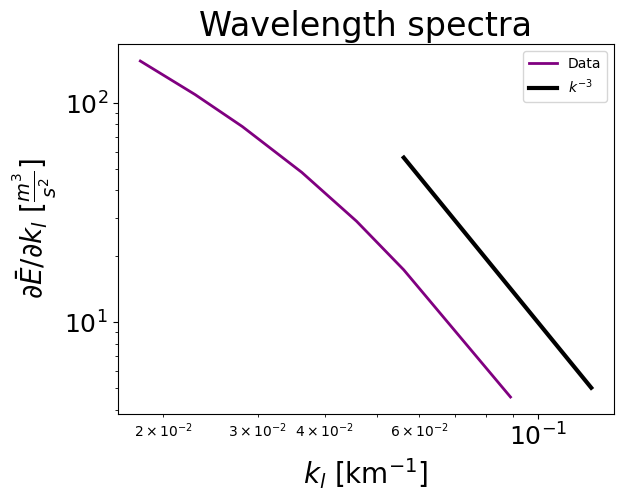

In [27]:
plt.plot(kmid[1:], (-de_high[1:] / dk[1:]) * 1000, label=r"Data", color='purple', linestyle='solid', linewidth=2)
plt.plot(kmid[0:3], kmid[0:3]**(-3) / 1e2, color='black', linestyle='solid', linewidth=3, label=r"$k^{-3}$")
plt.title("Wavelength spectra", fontsize=24)
plt.xscale("log")
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")
plt.xlabel(r"$k_l$ [km$^{-1}$]", fontsize=20)
plt.ylabel(r"$\partial \bar E / \partial k_l $ [$ \frac{m^3}{s^2} $]", fontsize=20)